In [3]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
from geodatasets import get_path 
from sqlalchemy import create_engine, text
from shapely.geometry import Point
import matplotlib.pyplot as plt

# --- Configuração do Banco de Dados ---
DB_USER = "db_user"
DB_PASSWORD = "123"
DB_HOST = "localhost"
DB_PORT = "5432"
DB_NAME = "ibd_db"

# --- Criação da Engine ---
connection_string = f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
try:
    engine = create_engine(connection_string)
    print("Conexão com o PostgreSQL estabelecida com sucesso!")
except Exception as e:
    engine = None
    print(f"Ocorreu um erro ao conectar ao banco de dados: {e}")


def run_query(query):
    """
    Executa uma consulta SQL e retorna um DataFrame do Pandas.
    """
    if engine:
        try:
            with engine.connect() as connection:
                df = pd.read_sql_query(text(query), connection)
                print("\nDataFrame carregado com sucesso")
                return df
        except Exception as e:
            print(f"Ocorreu um erro ao executar a consulta: {e}")
            return None
    else:
        print("A conexão com o banco de dados não foi estabelecida.")
        return None

Conexão com o PostgreSQL estabelecida com sucesso!


In [2]:
df_mun_local_uf = run_query("SELECT * FROM municipios;")
df_mun_local_uf


DataFrame carregado com sucesso


,cod_mun,nome_mun,fuso,lat_mun,long_mun,ddd,cod_uf
0,5200050.0,Abadia de Goiás,America/Sao_Paulo,-16.75730,-49.4412,62.0,52.0
1,3100104.0,Abadia dos Dourados,America/Sao_Paulo,-18.48310,-47.3916,34.0,31.0
2,5200100.0,Abadiânia,America/Sao_Paulo,-16.19700,-48.7057,62.0,52.0
3,3100203.0,Abaeté,America/Sao_Paulo,-19.15510,-45.4444,37.0,31.0
4,1500107.0,Abaetetuba,America/Sao_Paulo,-1.72183,-48.8788,91.0,15.0
...,...,...,...,...,...,...,...
5565,2933604.0,Xique-Xique,America/Sao_Paulo,-10.82300,-42.7245,74.0,29.0
5566,2517407.0,Zabelê,America/Sao_Paulo,-8.07901,-37.1057,83.0,25.0
5567,3557154.0,Zacarias,America/Sao_Paulo,-21.05060,-50.0552,18.0,35.0
5568,2114007.0,Zé Doca,America/Sao_Paulo,-3.27014,-45.6553,98.0,21.0


In [62]:
def map_df(df, name, title):
    
    colunas_essenciais = ['lat_mun', 'long_mun', 'quantidade']
    df.dropna(subset=colunas_essenciais, inplace=True)
    df['quantidade'] = pd.to_numeric(df['quantidade'], errors='coerce')
    df.dropna(subset=colunas_essenciais, inplace=True)
    
    if df.empty or df['quantidade'].max() == 0:
        print("DataFrame vazio ou sem dados de quantidade para gerar o mapa.")
        return

    q1 = df['quantidade'].quantile(0.25)
    q2 = df['quantidade'].quantile(0.50)
    q3 = df['quantidade'].quantile(0.75)
    q4_max = df['quantidade'].max()

    sizes = [20, 50, 100, 150, 250]
    colors = ['#ffffb2', '#fecc5c', '#fd8d3c', '#f03b20', '#000000']

    def assign_visuals(quantity):
        if quantity == q4_max:
            return pd.Series({'tamanho': sizes[4], 'cor': colors[4]})
        elif quantity <= q1:
            return pd.Series({'tamanho': sizes[0], 'cor': colors[0]})
        elif quantity <= q2:
            return pd.Series({'tamanho': sizes[1], 'cor': colors[1]})
        elif quantity <= q3:
            return pd.Series({'tamanho': sizes[2], 'cor': colors[2]})
        else:
            return pd.Series({'tamanho': sizes[3], 'cor': colors[3]})

    df[['tamanho_marcador', 'cor_marcador']] = df['quantidade'].apply(assign_visuals)
    
    gdf_municipios = gpd.GeoDataFrame(
        df,
        geometry=gpd.points_from_xy(df['long_mun'], df['lat_mun']),
        crs="EPSG:4326"
    )

    gdf_max = gdf_municipios[gdf_municipios['quantidade'] == q4_max]
    gdf_others = gdf_municipios[gdf_municipios['quantidade'] < q4_max]

    url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"
    world = gpd.read_file(url)
    brasil = world[world.NAME == "Brazil"]

    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_aspect('equal')
    brasil.plot(ax=ax, color='#e0e0e0', edgecolor='black', zorder=1)
    
    gdf_others.plot(
        ax=ax,
        marker='o',
        color=gdf_others['cor_marcador'],
        alpha=0.8,
        markersize=gdf_others['tamanho_marcador'],
        edgecolor='white',
        linewidth=0.5,
        zorder=2
    )

    gdf_max.plot(
        ax=ax,
        marker='o',
        color=gdf_max['cor_marcador'],
        alpha=1,
        markersize=gdf_max['tamanho_marcador'],
        edgecolor='cyan',
        linewidth=1.5,
        zorder=10
    )
    
    q1_label, q2_label, q3_label, q4_label = int(q1), int(q2), int(q3), int(q4_max)
    
    labels = [
        f'Até {q1_label}',
        f'{q1_label + 1} - {q2_label}',
        f'{q2_label + 1} - {q3_label}',
        f'Acima de {q3_label} (não máx.)',
        f'Máximo: {q4_label}'
    ]

    handles = []
    for i in range(len(sizes)):
        handles.append(plt.scatter([], [], s=sizes[i], c=colors[i], alpha=0.8, label=labels[i], edgecolor='white', linewidth=0.5))
    
    handles[-1].set_edgecolor('cyan')
    
    ax.legend(
        handles=handles,
        title="Quantidade",
        loc="lower right",
        labelspacing=2,
        borderpad=1.2,
        frameon=True,
        fontsize=10
    )

    ax.set_axis_off()
    ax.set_title(
        title,
        fontdict={'fontsize': '16', 'fontweight': '3'}
    )
    
    plt.tight_layout()
    plt.savefig(name+".png", dpi=300)
    plt.show()

In [94]:
def boxplot(df1, df2, df3,name, label1='Grupo 1', label2='Grupo 2', label3='Grupo 3'):

    data_to_plot = [
        df1['quantidade'].dropna(),
        df2['quantidade'].dropna(),
        df3['quantidade'].dropna()
    ]
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    box_patches = ax.boxplot(data_to_plot, patch_artist=True, vert=True)
    
    colors = ['#a1d99b', '#66c2a4', '#2ca25f']
    for patch, color in zip(box_patches['boxes'], colors):
        patch.set_facecolor(color)
        
    for median in box_patches['medians']:
        median.set(color='black', linewidth=2)

    ax.set_xticklabels([label1, label2, label3])
    ax.set_ylabel('Valores da Quantidade (em Escala Log)')
    ax.set_title('Distribuição de Quantidade por Grupo')
    ax.yaxis.grid(True, which='both', linestyle='--', linewidth=0.5)

    ax.set_yscale('log')
    
    plt.tight_layout()
    plt.savefig(name+".png", dpi=300)
    plt.show()

In [4]:
df_infeccao_municipio_dengue_2025 = run_query("SELECT m.cod_mun, m.nome_mun,m.long_mun, m.lat_mun, COUNT(*) AS quantidade FROM notificacao_de_infectados AS i INNER JOIN municipios AS m ON i.cod_mun_infec = m.cod_mun WHERE i.dt_notific >= '2025-01-01' AND i.tipo_infec = 1 GROUP BY m.cod_mun, m.nome_mun ORDER BY quantidade DESC;")
df_infeccao_municipio_dengue_2025


DataFrame carregado com sucesso


,cod_mun,nome_mun,long_mun,lat_mun,quantidade
0,3549805.0,São José do Rio Preto,-49.3758,-20.81130,39954
1,3550308.0,São Paulo,-46.6395,-23.53290,38462
2,3509502.0,Campinas,-47.0659,-22.90530,20633
3,3543402.0,Ribeirão Preto,-47.8099,-21.16990,17150
4,5208707.0,Goiânia,-49.2643,-16.68640,12204
...,...,...,...,...,...
3166,2307502.0,Lavras da Mangabeira,-38.9706,-6.74480,1
3167,3147808.0,Passa-Vinte,-44.2344,-22.20970,1
3168,1302405.0,Lábrea,-64.7948,-7.26413,1
3169,2514107.0,São João do Tigre,-36.8547,-8.07703,1


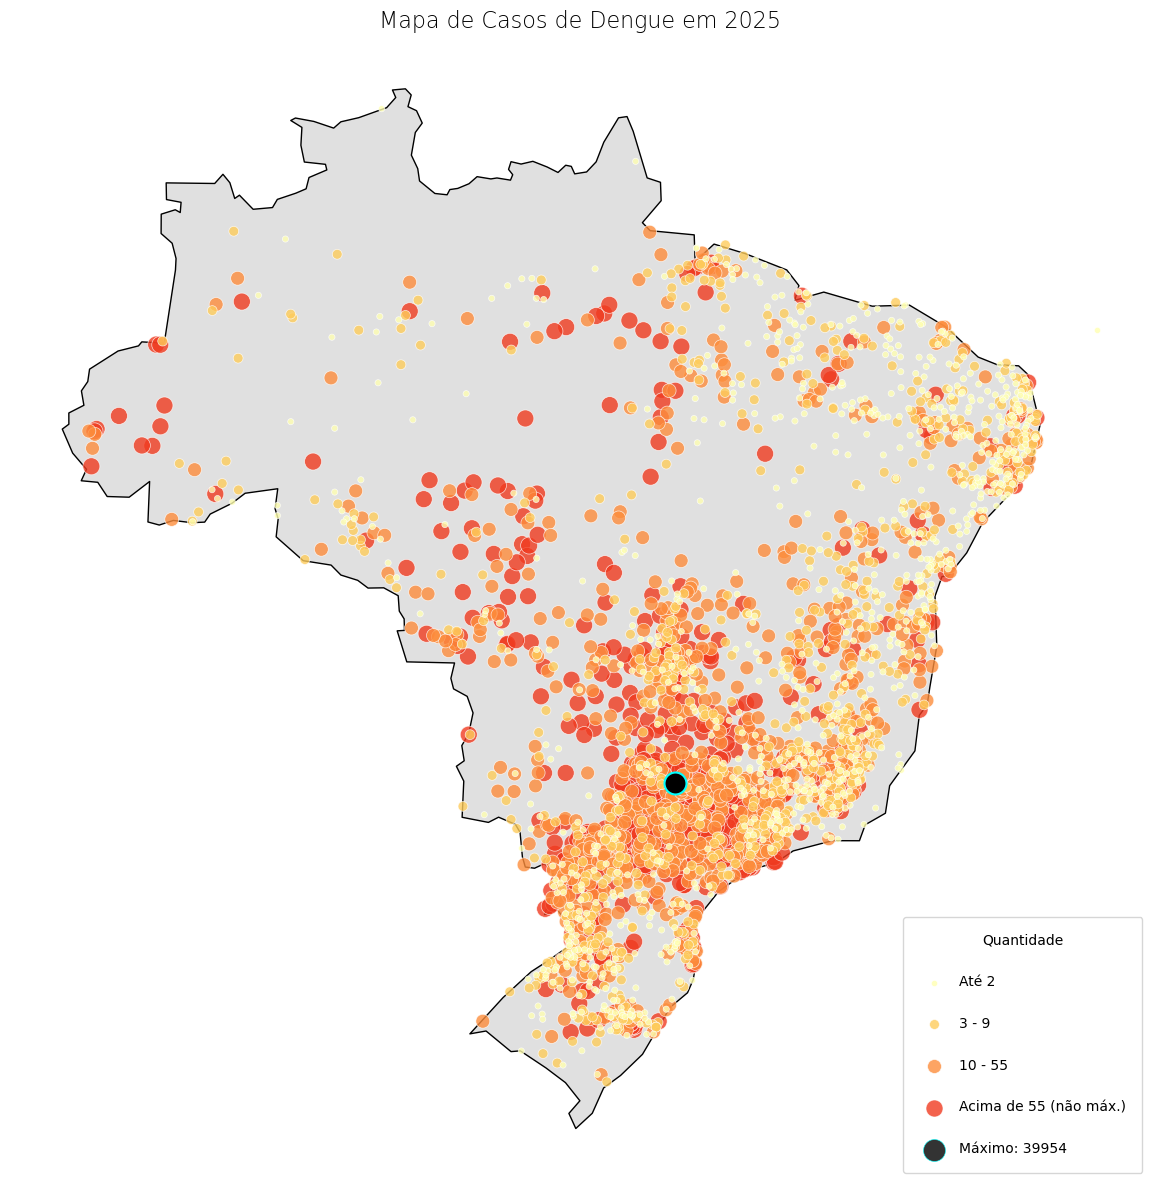

In [63]:
map_df(df_infeccao_municipio_dengue_2025,"mapa_d_2025","Mapa de Casos de Dengue em 2025")

In [6]:
df_infeccao_municipio_zika_2025 = run_query("SELECT m.cod_mun, m.nome_mun,m.long_mun, m.lat_mun, COUNT(*) AS quantidade FROM notificacao_de_infectados AS i INNER JOIN municipios AS m ON i.cod_mun_infec = m.cod_mun WHERE i.dt_notific >= '2025-01-01' AND i.tipo_infec = 2 GROUP BY m.cod_mun, m.nome_mun ORDER BY quantidade DESC;")
df_infeccao_municipio_zika_2025


DataFrame carregado com sucesso


,cod_mun,nome_mun,long_mun,lat_mun,quantidade
0,5106752.0,Pontes e Lacerda,-59.3435,-15.22190,353
1,5105101.0,Juara,-57.5244,-11.26390,73
2,5103007.0,Chapada dos Guimarães,-55.7499,-15.46430,22
3,5102504.0,Cáceres,-57.6818,-16.07640,18
4,5104104.0,Guarantã do Norte,-54.9121,-9.96218,14
...,...,...,...,...,...
134,2910727.0,Eunápolis,-39.5821,-16.37150,1
135,2100055.0,Açailândia,-47.5004,-4.94714,1
136,1508159.0,Uruará,-53.7396,-3.71519,1
137,2913606.0,Ilhéus,-39.0460,-14.79300,1


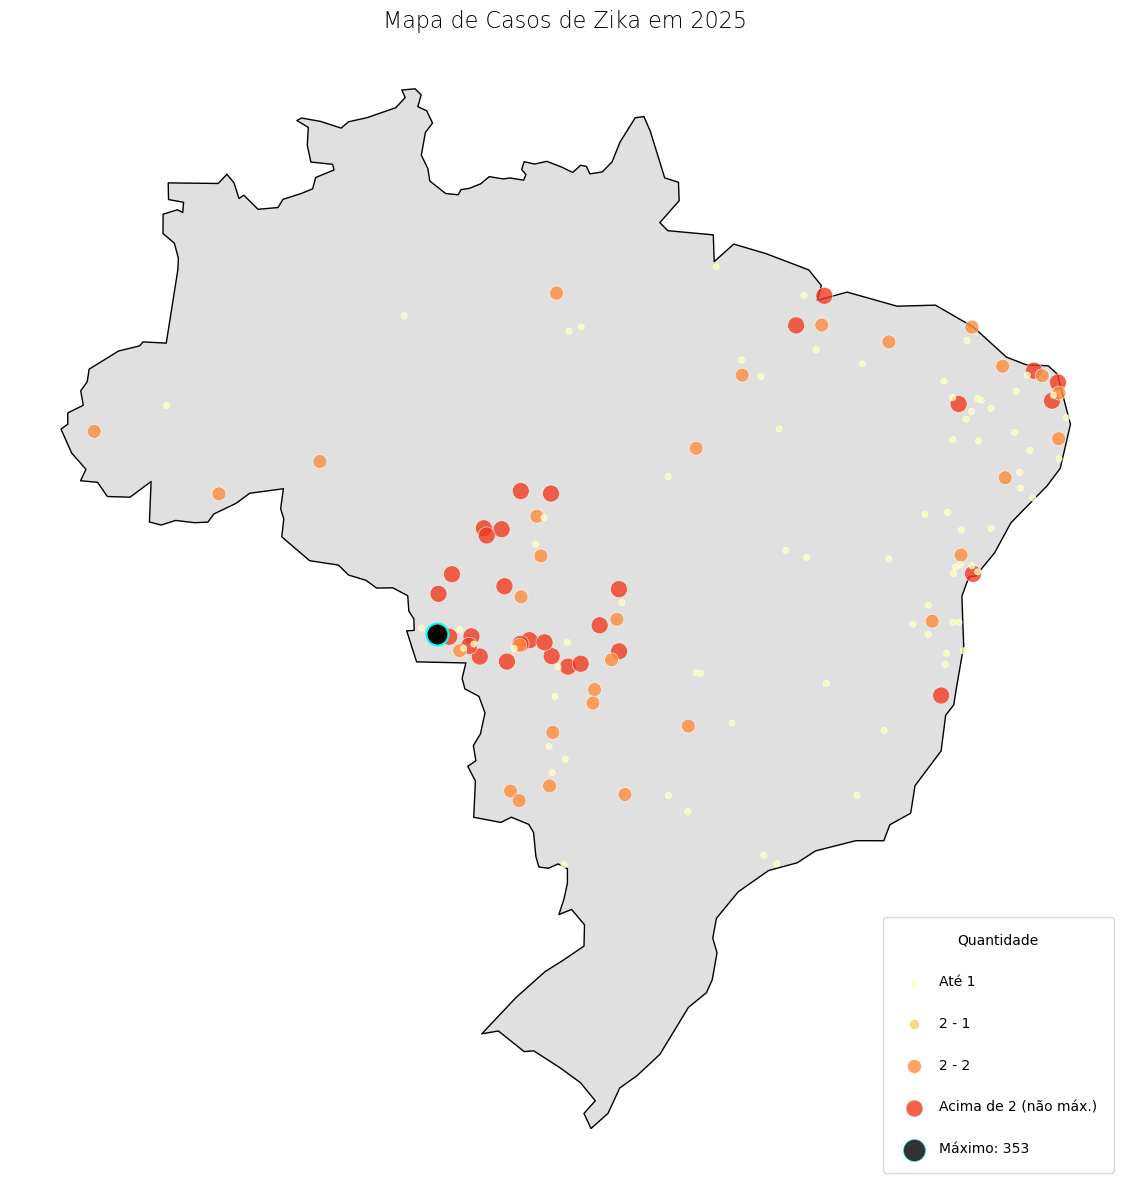

In [64]:
map_df(df_infeccao_municipio_zika_2025,"mapa_z_2025","Mapa de Casos de Zika em 2025")

In [8]:
df_infeccao_municipio_total_2025 = run_query("SELECT m.cod_mun, m.nome_mun,m.long_mun, m.lat_mun, COUNT(*) AS quantidade FROM notificacao_de_infectados AS i INNER JOIN municipios AS m ON i.cod_mun_infec = m.cod_mun WHERE i.dt_notific >= '2025-01-01' GROUP BY m.cod_mun, m.nome_mun ORDER BY quantidade DESC;")
df_infeccao_municipio_total_2025


DataFrame carregado com sucesso


,cod_mun,nome_mun,long_mun,lat_mun,quantidade
0,3549805.0,São José do Rio Preto,-49.3758,-20.8113,39954
1,3550308.0,São Paulo,-46.6395,-23.5329,38463
2,3509502.0,Campinas,-47.0659,-22.9053,20633
3,3543402.0,Ribeirão Preto,-47.8099,-21.1699,17150
4,5208707.0,Goiânia,-49.2643,-16.6864,12205
...,...,...,...,...,...
3180,4115853.0,Mercedes,-54.1618,-24.4538,1
3181,3168804.0,Tiradentes,-44.1744,-21.1102,1
3182,3146602.0,Paiva,-43.4088,-21.2913,1
3183,4304614.0,Canudos do Vale,-52.2374,-29.3271,1


In [9]:
df_infeccao_municipio_dengue_2024 = run_query("SELECT m.cod_mun, m.nome_mun,m.long_mun, m.lat_mun, COUNT(*) AS quantidade FROM notificacao_de_infectados AS i INNER JOIN municipios AS m ON i.cod_mun_infec = m.cod_mun WHERE i.dt_notific BETWEEN '2024-01-01' AND '2024-12-31' AND i.tipo_infec = 1 GROUP BY m.cod_mun, m.nome_mun ORDER BY quantidade DESC;")
df_infeccao_municipio_dengue_2024 


DataFrame carregado com sucesso


,cod_mun,nome_mun,long_mun,lat_mun,quantidade
0,3550308.0,São Paulo,-46.6395,-23.5329,445466
1,4209102.0,Joinville,-48.8487,-26.3045,78587
2,3518800.0,Guarulhos,-46.5333,-23.4538,63479
3,3106200.0,Belo Horizonte,-43.9266,-19.9102,63093
4,3549904.0,São José dos Campos,-45.8841,-23.1896,62302
...,...,...,...,...,...
4509,3303807.0,Paraty,-44.7175,-23.2221,1
4510,4308052.0,Faxinalzinho,-52.6789,-27.4238,1
4511,4308003.0,Faxinal do Soturno,-53.4484,-29.5788,1
4512,4307559.0,Estação,-52.2635,-27.9135,1


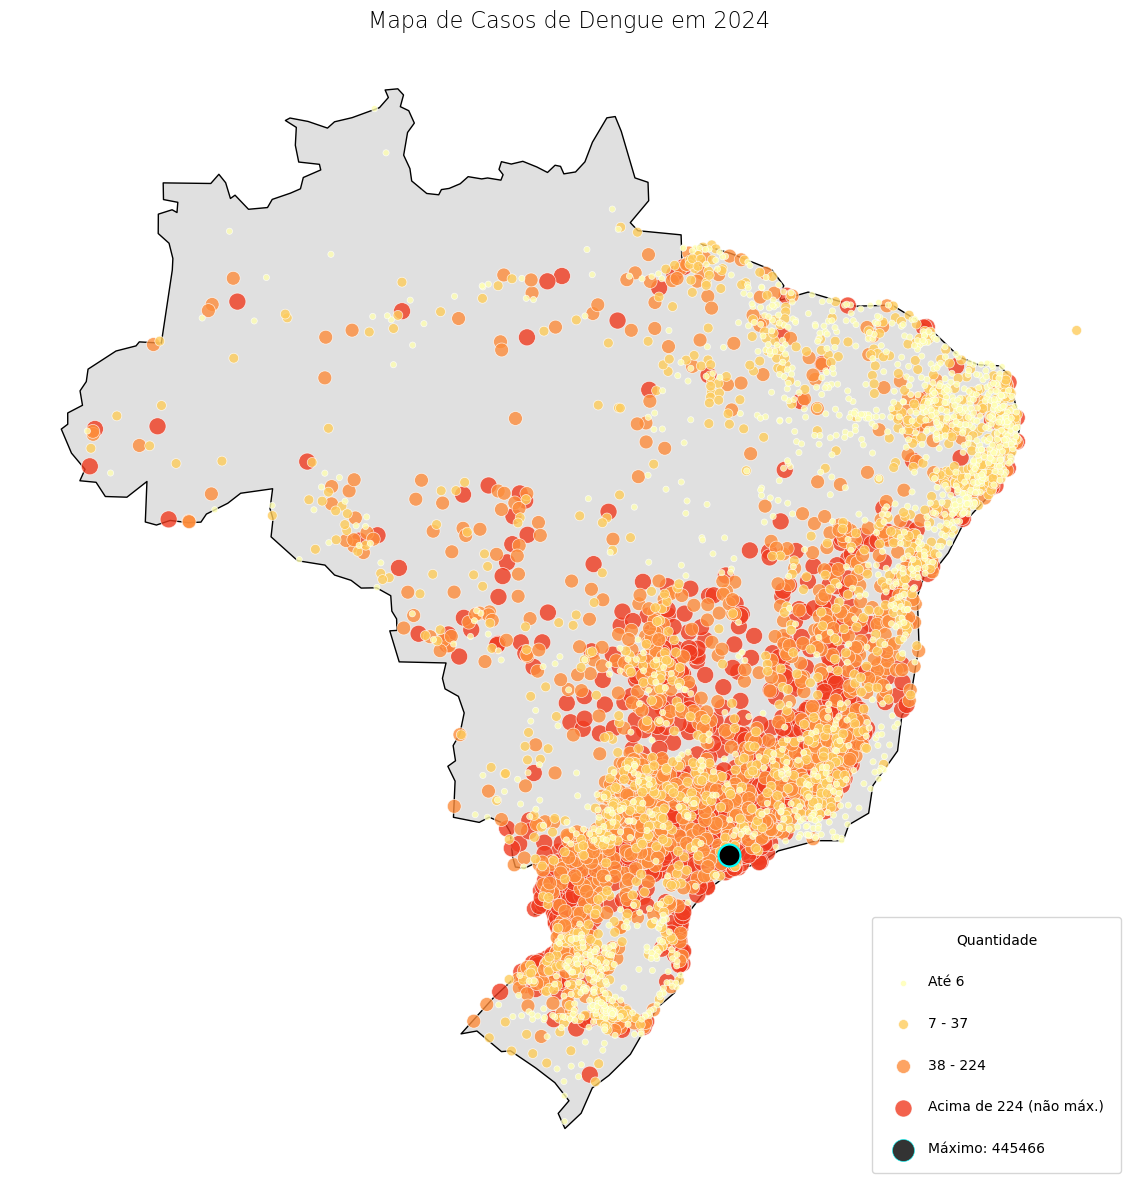

In [65]:
map_df(df_infeccao_municipio_dengue_2024,"mapa_d_2024","Mapa de Casos de Dengue em 2024")

In [11]:
df_infeccao_municipio_zika_2024 = run_query("SELECT m.cod_mun, m.nome_mun,m.long_mun, m.lat_mun, COUNT(*) AS quantidade FROM notificacao_de_infectados AS i INNER JOIN municipios AS m ON i.cod_mun_infec = m.cod_mun WHERE i.dt_notific BETWEEN '2024-01-01' AND '2024-12-31' AND i.tipo_infec = 2 GROUP BY m.cod_mun, m.nome_mun ORDER BY quantidade DESC;")
df_infeccao_municipio_zika_2024 


DataFrame carregado com sucesso


,cod_mun,nome_mun,long_mun,lat_mun,quantidade
0,2402600.0,Ceará-Mirim,-35.4247,-5.64323,153
1,2109908.0,Santa Inês,-45.3774,-3.65112,143
2,2928901.0,São Desidério,-44.9769,-12.35720,128
3,2913507.0,Iguaí,-40.0894,-14.75280,100
4,2405108.0,Jandaíra,-36.1278,-5.35211,85
...,...,...,...,...,...
398,2933208.0,Vera Cruz,-38.6153,-12.95680,1
399,2933505.0,Wenceslau Guimarães,-39.4762,-13.69080,1
400,3102308.0,Alvinópolis,-43.0535,-20.10980,1
401,3103504.0,Araguari,-48.1934,-18.64560,1


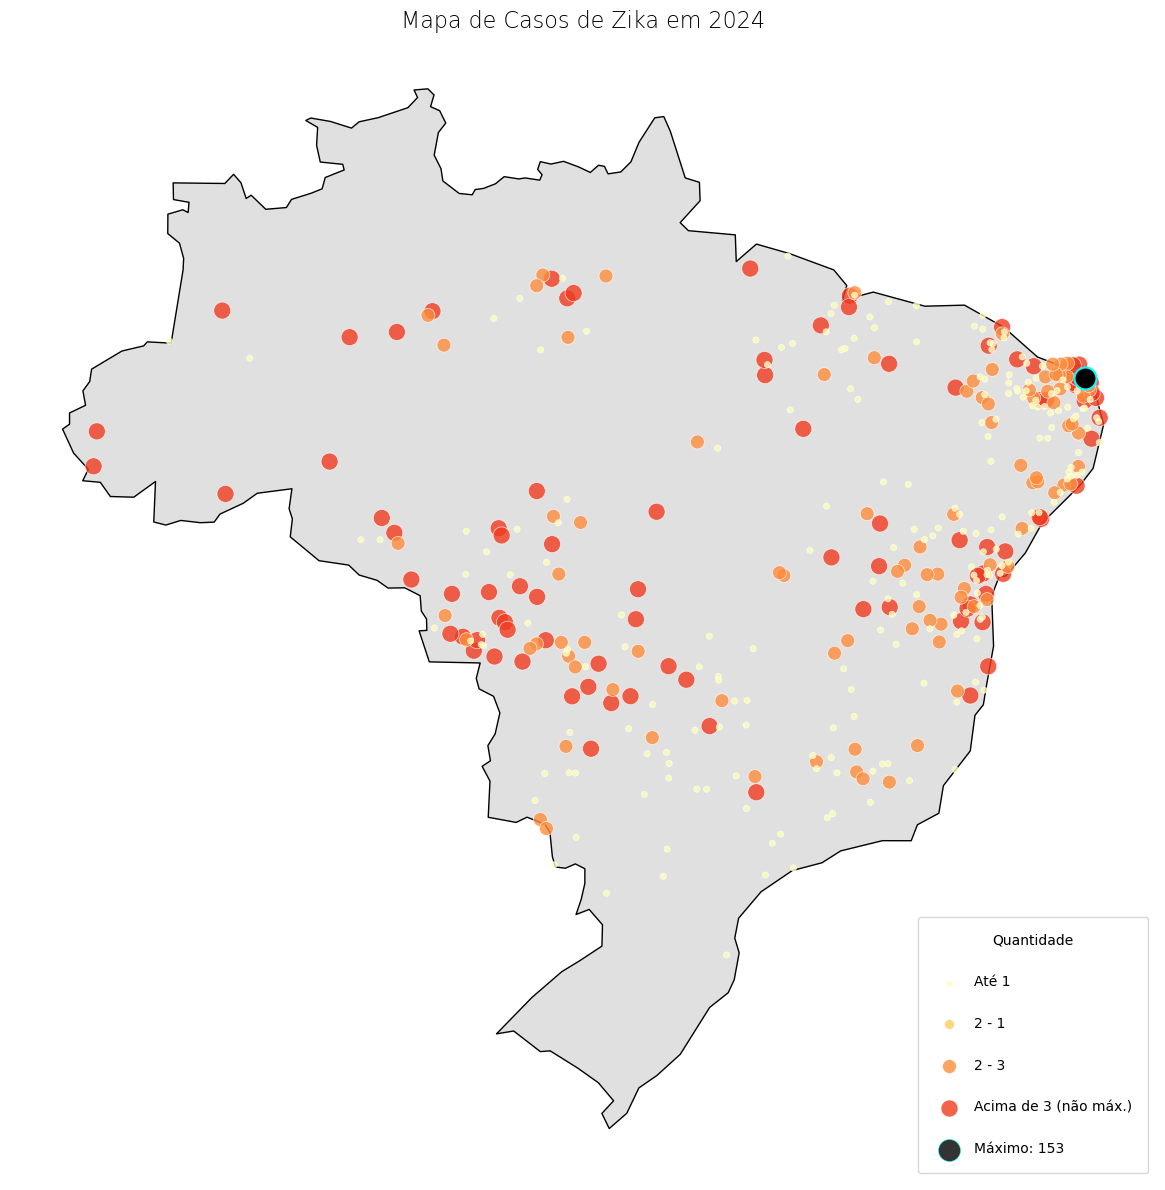

In [66]:
map_df(df_infeccao_municipio_zika_2024,"mapa_z_2024","Mapa de Casos de Zika em 2024")

In [13]:
df_infeccao_municipio_total_2024 = run_query("SELECT m.cod_mun, m.nome_mun,m.long_mun, m.lat_mun, COUNT(*) AS quantidade FROM notificacao_de_infectados AS i INNER JOIN municipios AS m ON i.cod_mun_infec = m.cod_mun WHERE i.dt_notific BETWEEN '2024-01-01' AND '2024-12-31' GROUP BY m.cod_mun, m.nome_mun ORDER BY quantidade DESC;")
df_infeccao_municipio_total_2024 


DataFrame carregado com sucesso


,cod_mun,nome_mun,long_mun,lat_mun,quantidade
0,3550308.0,São Paulo,-46.6395,-23.53290,445466
1,4209102.0,Joinville,-48.8487,-26.30450,78587
2,3518800.0,Guarulhos,-46.5333,-23.45380,63479
3,3106200.0,Belo Horizonte,-43.9266,-19.91020,63093
4,3549904.0,São José dos Campos,-45.8841,-23.18960,62302
...,...,...,...,...,...
4530,2509396.0,Maturéia,-37.3510,-7.26188,1
4531,2509404.0,Mogeiro,-35.4832,-7.28517,1
4532,2511004.0,Pedra Branca,-38.0689,-7.42169,1
4533,2511509.0,Pilar,-35.2523,-7.26403,1


In [14]:
df_infeccao_municipio_dengue_2023 = run_query("SELECT m.cod_mun, m.nome_mun,m.long_mun, m.lat_mun, COUNT(*) AS quantidade FROM notificacao_de_infectados AS i INNER JOIN municipios AS m ON i.cod_mun_infec = m.cod_mun WHERE i.dt_notific BETWEEN '2023-01-01' AND '2023-12-31' AND i.tipo_infec = 1 GROUP BY m.cod_mun, m.nome_mun ORDER BY quantidade DESC;")
df_infeccao_municipio_dengue_2023


DataFrame carregado com sucesso


,cod_mun,nome_mun,long_mun,lat_mun,quantidade
0,4209102.0,Joinville,-48.8487,-26.30450,40308
1,3541406.0,Presidente Prudente,-51.3925,-22.12070,25344
2,4113700.0,Londrina,-51.1691,-23.30400,24324
3,3170206.0,Uberlândia,-48.2749,-18.91410,21079
4,4205407.0,Florianópolis,-48.5477,-27.59450,16516
...,...,...,...,...,...
3666,4308250.0,Floriano Peixoto,-52.0838,-27.86140,1
3667,4308300.0,Fontoura Xavier,-52.3445,-28.98170,1
3668,1505650.0,Placas,-54.2124,-3.86813,1
3669,5206909.0,Davinópolis,-47.5568,-18.15010,1


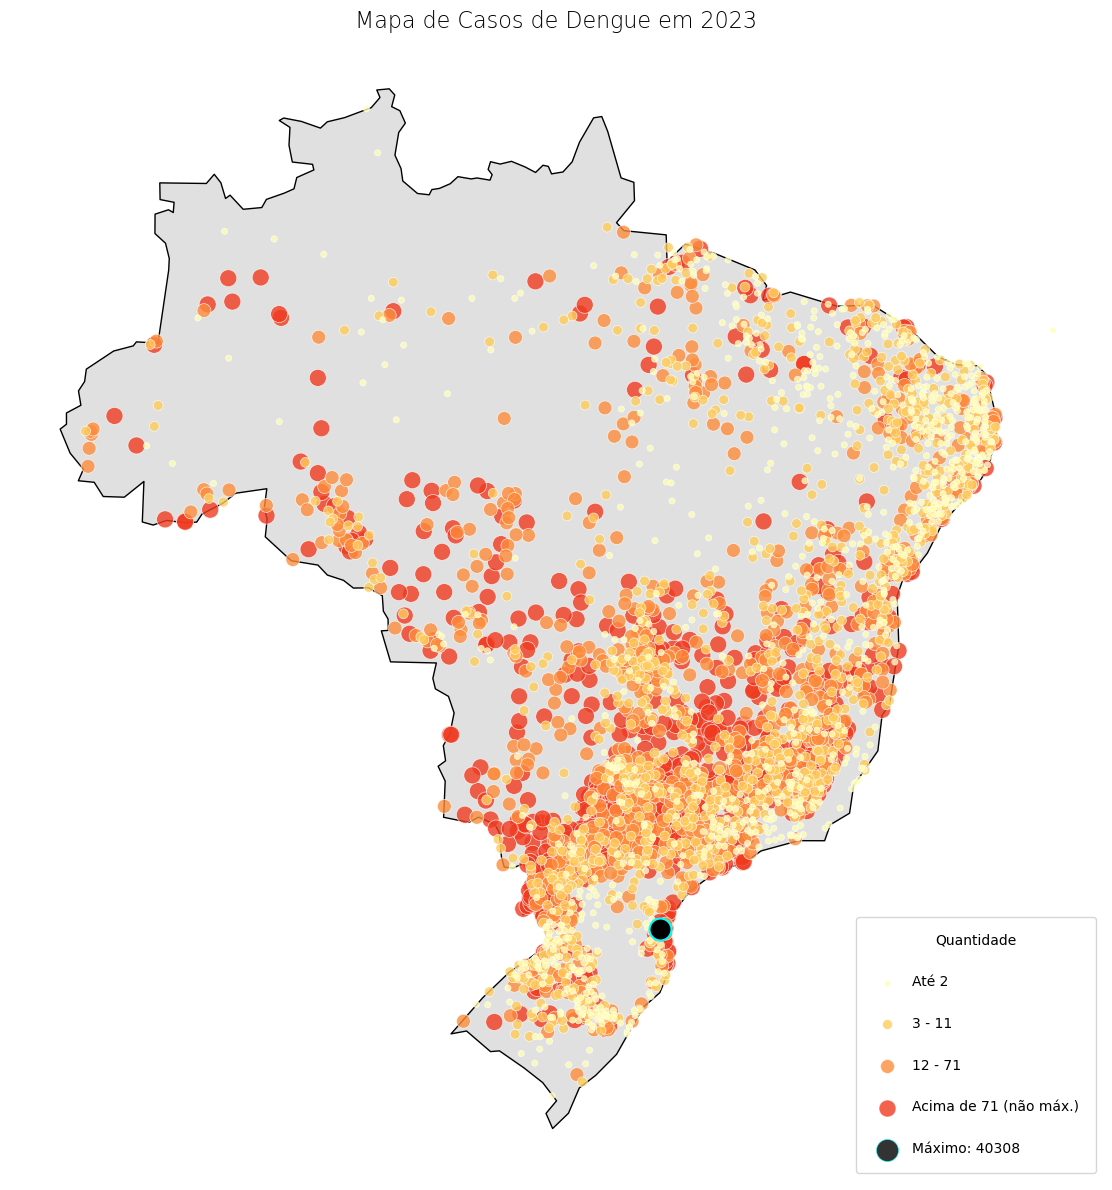

In [67]:
map_df(df_infeccao_municipio_dengue_2023,"mapa_d_2023","Mapa de Casos de Dengue em 2023")

In [16]:
df_infeccao_municipio_zika_2023 = run_query("SELECT m.cod_mun, m.nome_mun,m.long_mun, m.lat_mun, COUNT(*) AS quantidade FROM notificacao_de_infectados AS i INNER JOIN municipios AS m ON i.cod_mun_infec = m.cod_mun WHERE i.dt_notific BETWEEN '2023-01-01' AND '2023-12-31' AND i.tipo_infec = 2 GROUP BY m.cod_mun, m.nome_mun ORDER BY quantidade DESC;")
df_infeccao_municipio_zika_2023


DataFrame carregado com sucesso


,cod_mun,nome_mun,long_mun,lat_mun,quantidade
0,2927408.0,Salvador,-38.5011,-12.97180,280
1,5106257.0,Nova Xavantina,-52.3502,-14.67710,141
2,5200258.0,Águas Lindas de Goiás,-48.2816,-15.76170,95
3,2409506.0,Pedra Grande,-35.8760,-5.14988,74
4,2914802.0,Itabuna,-39.2781,-14.78760,67
...,...,...,...,...,...
378,5210208.0,Iporá,-51.1180,-16.43980,1
379,5212501.0,Luziânia,-47.9500,-16.25300,1
380,5213103.0,Mineiros,-52.5537,-17.56540,1
381,5219308.0,Santa Helena de Goiás,-50.5977,-17.81150,1


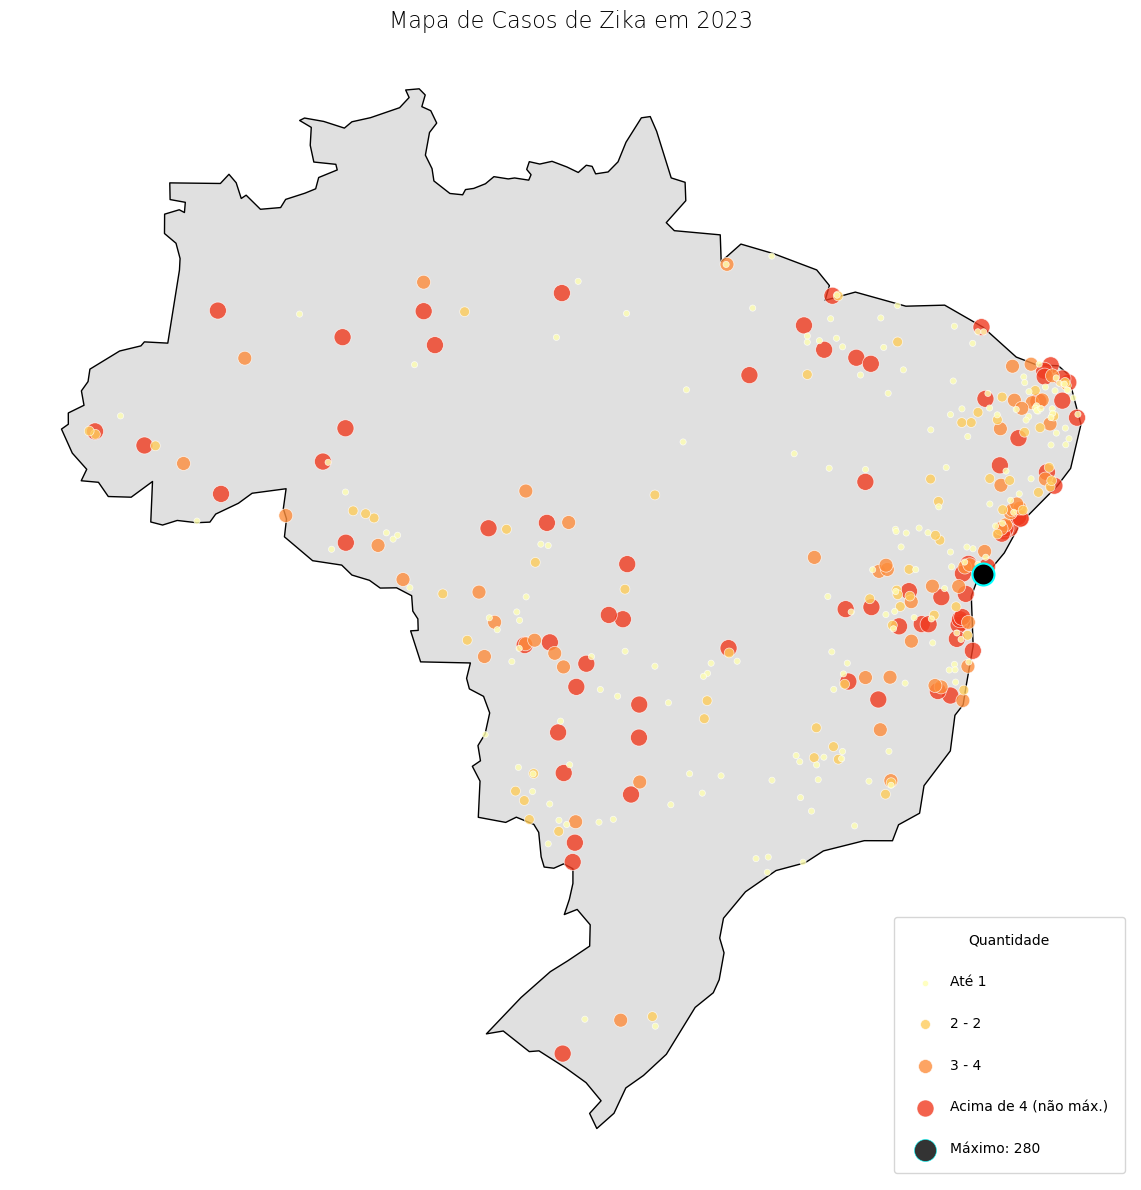

In [68]:
map_df(df_infeccao_municipio_zika_2023,"mapa_z_2023","Mapa de Casos de Zika em 2023")

In [18]:
df_infeccao_municipio_total_2023 = run_query("SELECT m.cod_mun, m.nome_mun,m.long_mun, m.lat_mun, COUNT(*) AS quantidade FROM notificacao_de_infectados AS i INNER JOIN municipios AS m ON i.cod_mun_infec = m.cod_mun WHERE i.dt_notific BETWEEN '2023-01-01' AND '2023-12-31' GROUP BY m.cod_mun, m.nome_mun ORDER BY quantidade DESC;")
df_infeccao_municipio_total_2023


DataFrame carregado com sucesso


,cod_mun,nome_mun,long_mun,lat_mun,quantidade
0,4209102.0,Joinville,-48.8487,-26.30450,40308
1,3541406.0,Presidente Prudente,-51.3925,-22.12070,25344
2,4113700.0,Londrina,-51.1691,-23.30400,24324
3,3170206.0,Uberlândia,-48.2749,-18.91410,21079
4,4205407.0,Florianópolis,-48.5477,-27.59450,16516
...,...,...,...,...,...
3699,3132008.0,Itacambira,-43.3069,-17.06250,1
3700,1503754.0,Jacareacanga,-57.7544,-6.21469,1
3701,2403707.0,Felipe Guerra,-37.6875,-5.59274,1
3702,3134707.0,Jacinto,-40.2950,-16.14280,1


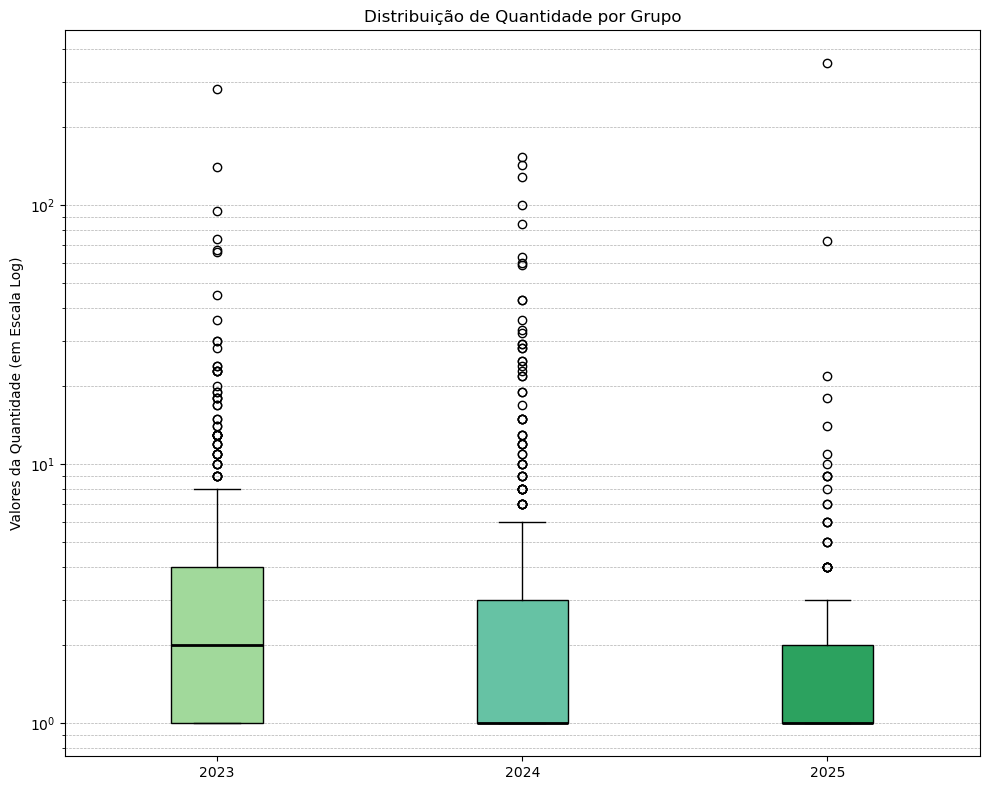

In [97]:
boxplot(df_infeccao_municipio_zika_2023,df_infeccao_municipio_zika_2024,df_infeccao_municipio_zika_2025,"box_plot_z","2023","2024","2025")

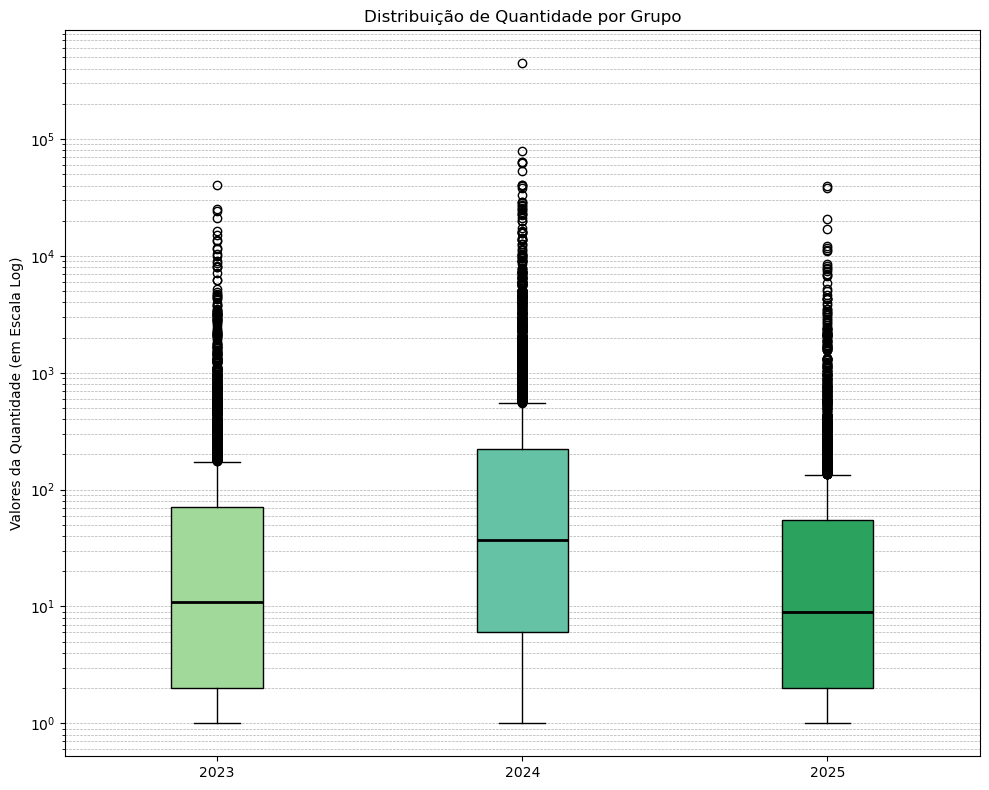

In [96]:
boxplot(df_infeccao_municipio_dengue_2023,df_infeccao_municipio_dengue_2024,df_infeccao_municipio_dengue_2025,"box_plot_d","2023","2024","2025")

In [19]:
df_federativa_2025_total = run_query("SELECT u.nome, COUNT(*) AS quantidade FROM (notificacao_de_infectados AS i INNER JOIN municipios AS m ON i.cod_mun_infec = m.cod_mun) im NATURAL JOIN unidade_federativa u WHERE im.dt_notific >= '2025-01-01' GROUP BY u.nome ORDER BY quantidade DESC;")
df_federativa_2025_total


DataFrame carregado com sucesso


,nome,quantidade
0,São Paulo,427636
1,Paraná,45736
2,Minas Gerais,44185
3,Goiás,34442
4,Mato Grosso,13459
5,Rio Grande do Sul,13033
6,Pará,5649
7,Santa Catarina,4576
8,Bahia,4172
9,Mato Grosso do Sul,3159


In [20]:
df_federativa_2025_dengue = run_query("SELECT u.nome, COUNT(*) AS quantidade FROM (notificacao_de_infectados AS i INNER JOIN municipios AS m ON i.cod_mun_infec = m.cod_mun) im NATURAL JOIN unidade_federativa u WHERE im.dt_notific >= '2025-01-01' AND im.tipo_infec = 1 GROUP BY u.nome ORDER BY quantidade DESC;")
df_federativa_2025_dengue


DataFrame carregado com sucesso


,nome,quantidade
0,São Paulo,427632
1,Paraná,45736
2,Minas Gerais,44179
3,Goiás,34440
4,Rio Grande do Sul,13033
5,Mato Grosso,12843
6,Pará,5641
7,Santa Catarina,4576
8,Bahia,4140
9,Mato Grosso do Sul,3144


In [21]:
df_federativa_2025_zika = run_query("SELECT u.nome, COUNT(*) AS quantidade FROM (notificacao_de_infectados AS i INNER JOIN municipios AS m ON i.cod_mun_infec = m.cod_mun) im NATURAL JOIN unidade_federativa u WHERE im.dt_notific >= '2025-01-01' AND im.tipo_infec = 2 GROUP BY u.nome ORDER BY quantidade DESC;")
df_federativa_2025_zika


DataFrame carregado com sucesso


,nome,quantidade
0,Mato Grosso,616
1,Bahia,32
2,Rio Grande do Norte,23
3,Maranhão,22
4,Mato Grosso do Sul,15
5,Ceará,10
6,Pará,8
7,Pernambuco,7
8,Minas Gerais,6
9,Acre,4


In [22]:
df_federativa_2024_total = run_query("SELECT u.nome, COUNT(*) AS quantidade FROM (notificacao_de_infectados AS i INNER JOIN municipios AS m ON i.cod_mun_infec = m.cod_mun) im NATURAL JOIN unidade_federativa u WHERE im.dt_notific BETWEEN '2024-01-01' AND '2024-12-31' GROUP BY u.nome ORDER BY quantidade DESC;")
df_federativa_2024_total


DataFrame carregado com sucesso


,nome,quantidade
0,São Paulo,1452291
1,Minas Gerais,682046
2,Paraná,414658
3,Santa Catarina,206522
4,Goiás,205182
5,Rio Grande do Sul,110388
6,Bahia,63694
7,Mato Grosso,30046
8,Alagoas,12068
9,Pará,11241


In [23]:
df_federativa_2024_dengue = run_query("SELECT u.nome, COUNT(*) AS quantidade FROM (notificacao_de_infectados AS i INNER JOIN municipios AS m ON i.cod_mun_infec = m.cod_mun) im NATURAL JOIN unidade_federativa u WHERE im.dt_notific BETWEEN '2024-01-01' AND '2024-12-31' AND im.tipo_infec = 1 GROUP BY u.nome ORDER BY quantidade DESC;")
df_federativa_2024_dengue


DataFrame carregado com sucesso


,nome,quantidade
0,São Paulo,1452276
1,Minas Gerais,681991
2,Paraná,414655
3,Santa Catarina,206521
4,Goiás,205153
5,Rio Grande do Sul,110388
6,Bahia,63185
7,Mato Grosso,29730
8,Alagoas,12016
9,Pará,11191


In [24]:
df_federativa_2024_zika = run_query("SELECT u.nome, COUNT(*) AS quantidade FROM (notificacao_de_infectados AS i INNER JOIN municipios AS m ON i.cod_mun_infec = m.cod_mun) im NATURAL JOIN unidade_federativa u WHERE im.dt_notific BETWEEN '2024-01-01' AND '2024-12-31' AND im.tipo_infec = 2 GROUP BY u.nome ORDER BY quantidade DESC;")
df_federativa_2024_zika


DataFrame carregado com sucesso


,nome,quantidade
0,Rio Grande do Norte,570
1,Bahia,509
2,Mato Grosso,316
3,Maranhão,221
4,Ceará,96
5,Acre,68
6,Amazonas,65
7,Rondônia,65
8,Minas Gerais,55
9,Alagoas,52


In [25]:
df_federativa_2023_total = run_query("SELECT u.nome, COUNT(*) AS quantidade FROM (notificacao_de_infectados AS i INNER JOIN municipios AS m ON i.cod_mun_infec = m.cod_mun) im NATURAL JOIN unidade_federativa u WHERE im.dt_notific BETWEEN '2023-01-01' AND '2023-12-31' GROUP BY u.nome ORDER BY quantidade DESC;")
df_federativa_2023_total


DataFrame carregado com sucesso


,nome,quantidade
0,São Paulo,221462
1,Minas Gerais,194702
2,Paraná,103063
3,Santa Catarina,89319
4,Goiás,44425
5,Mato Grosso do Sul,29322
6,Rio Grande do Sul,23676
7,Mato Grosso,19636
8,Bahia,16513
9,Ceará,6896


In [26]:
df_federativa_2023_dengue = run_query("SELECT u.nome, COUNT(*) AS quantidade FROM (notificacao_de_infectados AS i INNER JOIN municipios AS m ON i.cod_mun_infec = m.cod_mun) im NATURAL JOIN unidade_federativa u WHERE im.dt_notific BETWEEN '2023-01-01' AND '2023-12-31' AND im.tipo_infec = 1 GROUP BY u.nome ORDER BY quantidade DESC;")
df_federativa_2023_dengue


DataFrame carregado com sucesso


,nome,quantidade
0,São Paulo,221454
1,Minas Gerais,194644
2,Paraná,103063
3,Santa Catarina,89319
4,Goiás,44304
5,Mato Grosso do Sul,29241
6,Rio Grande do Sul,23658
7,Mato Grosso,19284
8,Bahia,15807
9,Ceará,6864


In [27]:
df_federativa_2023_zika = run_query("SELECT u.nome, COUNT(*) AS quantidade FROM (notificacao_de_infectados AS i INNER JOIN municipios AS m ON i.cod_mun_infec = m.cod_mun) im NATURAL JOIN unidade_federativa u WHERE im.dt_notific BETWEEN '2023-01-01' AND '2023-12-31' AND im.tipo_infec = 2 GROUP BY u.nome ORDER BY quantidade DESC;")
df_federativa_2023_zika


DataFrame carregado com sucesso


,nome,quantidade
0,Bahia,706
1,Mato Grosso,352
2,Rio Grande do Norte,203
3,Sergipe,138
4,Goiás,121
5,Amazonas,107
6,Maranhão,86
7,Mato Grosso do Sul,81
8,Paraíba,74
9,Acre,59


In [28]:
df_regiao_2025_total = run_query("SELECT u.regiao, COUNT(*) AS quantidade FROM (notificacao_de_infectados AS i INNER JOIN municipios AS m ON i.cod_mun_infec = m.cod_mun) im NATURAL JOIN unidade_federativa u WHERE im.dt_notific >= '2025-01-01' GROUP BY u.regiao ORDER BY quantidade DESC;")
df_regiao_2025_total


DataFrame carregado com sucesso


,regiao,quantidade
0,Sudeste,471857
1,Sul,63345
2,Centro-Oeste,51099
3,Nordeste,11308
4,Norte,10407


In [29]:
df_regiao_2025_dengue = run_query("SELECT u.regiao, COUNT(*) AS quantidade FROM (notificacao_de_infectados AS i INNER JOIN municipios AS m ON i.cod_mun_infec = m.cod_mun) im NATURAL JOIN unidade_federativa u WHERE im.dt_notific >= '2025-01-01' AND im.tipo_infec = 1 GROUP BY u.regiao ORDER BY quantidade DESC;")
df_regiao_2025_dengue


DataFrame carregado com sucesso


,regiao,quantidade
0,Sudeste,471847
1,Sul,63345
2,Centro-Oeste,50466
3,Nordeste,11202
4,Norte,10391


In [30]:
df_regiao_2025_zika = run_query("SELECT u.regiao, COUNT(*) AS quantidade FROM (notificacao_de_infectados AS i INNER JOIN municipios AS m ON i.cod_mun_infec = m.cod_mun) im NATURAL JOIN unidade_federativa u WHERE im.dt_notific >= '2025-01-01' AND im.tipo_infec = 2 GROUP BY u.regiao ORDER BY quantidade DESC;")
df_regiao_2025_zika


DataFrame carregado com sucesso


,regiao,quantidade
0,Centro-Oeste,633
1,Nordeste,106
2,Norte,16
3,Sudeste,10


In [31]:
df_regiao_2024_total = run_query("SELECT u.regiao, COUNT(*) AS quantidade FROM (notificacao_de_infectados AS i INNER JOIN municipios AS m ON i.cod_mun_infec = m.cod_mun) im NATURAL JOIN unidade_federativa u WHERE im.dt_notific BETWEEN '2024-01-01' AND '2024-12-31' GROUP BY u.regiao ORDER BY quantidade DESC;")
df_regiao_2024_total


DataFrame carregado com sucesso


,regiao,quantidade
0,Sudeste,2134676
1,Sul,731568
2,Centro-Oeste,245867
3,Nordeste,107258
4,Norte,20148


In [32]:
df_regiao_2024_dengue = run_query("SELECT u.regiao, COUNT(*) AS quantidade FROM (notificacao_de_infectados AS i INNER JOIN municipios AS m ON i.cod_mun_infec = m.cod_mun) im NATURAL JOIN unidade_federativa u WHERE im.dt_notific BETWEEN '2024-01-01' AND '2024-12-31' AND im.tipo_infec = 1 GROUP BY u.regiao ORDER BY quantidade DESC;")
df_regiao_2024_dengue


DataFrame carregado com sucesso


,regiao,quantidade
0,Sudeste,2134605
1,Sul,731564
2,Centro-Oeste,245493
3,Nordeste,105724
4,Norte,19898


In [33]:
df_regiao_2024_zika = run_query("SELECT u.regiao, COUNT(*) AS quantidade FROM (notificacao_de_infectados AS i INNER JOIN municipios AS m ON i.cod_mun_infec = m.cod_mun) im NATURAL JOIN unidade_federativa u WHERE im.dt_notific BETWEEN '2024-01-01' AND '2024-12-31' AND im.tipo_infec = 2 GROUP BY u.regiao ORDER BY quantidade DESC;")
df_regiao_2024_zika


DataFrame carregado com sucesso


,regiao,quantidade
0,Nordeste,1534
1,Centro-Oeste,374
2,Norte,250
3,Sudeste,71
4,Sul,4


In [34]:
df_regiao_2023_total = run_query("SELECT u.regiao, COUNT(*) AS quantidade FROM (notificacao_de_infectados AS i INNER JOIN municipios AS m ON i.cod_mun_infec = m.cod_mun) im NATURAL JOIN unidade_federativa u WHERE im.dt_notific BETWEEN '2023-01-01' AND '2023-12-31' GROUP BY u.regiao ORDER BY quantidade DESC;")
df_regiao_2023_total


DataFrame carregado com sucesso


,regiao,quantidade
0,Sudeste,416272
1,Sul,216058
2,Centro-Oeste,93505
3,Nordeste,41235
4,Norte,13600


In [35]:
df_regiao_2023_dengue = run_query("SELECT u.regiao, COUNT(*) AS quantidade FROM (notificacao_de_infectados AS i INNER JOIN municipios AS m ON i.cod_mun_infec = m.cod_mun) im NATURAL JOIN unidade_federativa u WHERE im.dt_notific BETWEEN '2023-01-01' AND '2023-12-31' AND im.tipo_infec = 1 GROUP BY u.regiao ORDER BY quantidade DESC;")
df_regiao_2023_dengue


DataFrame carregado com sucesso


,regiao,quantidade
0,Sudeste,416205
1,Sul,216040
2,Centro-Oeste,92951
3,Nordeste,39910
4,Norte,13379


In [36]:
df_regiao_2023_zika = run_query("SELECT u.regiao, COUNT(*) AS quantidade FROM (notificacao_de_infectados AS i INNER JOIN municipios AS m ON i.cod_mun_infec = m.cod_mun) im NATURAL JOIN unidade_federativa u WHERE im.dt_notific BETWEEN '2023-01-01' AND '2023-12-31' AND im.tipo_infec = 2 GROUP BY u.regiao ORDER BY quantidade DESC;")
df_regiao_2023_zika


DataFrame carregado com sucesso


,regiao,quantidade
0,Nordeste,1325
1,Centro-Oeste,554
2,Norte,221
3,Sudeste,67
4,Sul,18


In [37]:
df_raca = run_query("SELECT r.desc, COUNT(*) AS quantidade FROM notificacao_de_infectados AS i INNER JOIN raca AS r ON i.raca = r.id GROUP BY r.desc ORDER BY quantidade DESC;")
df_raca


DataFrame carregado com sucesso


,desc,quantidade
0,Branca,2301501
1,Parda,1447862
2,Ignorar,602612
3,Preta,225476
4,Amarela,41478
5,Indígena,9274


In [38]:
df_raca_dengue = run_query("SELECT r.desc, COUNT(*) AS quantidade FROM notificacao_de_infectados AS i INNER JOIN raca AS r ON i.raca = r.id AND i.tipo_infec = 1 GROUP BY r.desc ORDER BY quantidade DESC;")
df_raca_dengue


DataFrame carregado com sucesso


,desc,quantidade
0,Branca,2300453
1,Parda,1444632
2,Ignorar,602186
3,Preta,225112
4,Amarela,41414
5,Indígena,9223


In [39]:
df_raca_zika = run_query("SELECT r.desc, COUNT(*) AS quantidade FROM notificacao_de_infectados AS i INNER JOIN raca AS r ON i.raca = r.id AND i.tipo_infec = 2 GROUP BY r.desc ORDER BY quantidade DESC;")
df_raca_zika


DataFrame carregado com sucesso


,desc,quantidade
0,Parda,3230
1,Branca,1048
2,Ignorar,426
3,Preta,364
4,Amarela,64
5,Indígena,51


In [40]:
df_escolaridade = run_query("SELECT e.desc, COUNT(*) AS quantidade FROM notificacao_de_infectados AS i INNER JOIN escolaridade AS e ON i.escolaridade = e.id GROUP BY e.desc ORDER BY quantidade DESC;")
df_escolaridade


DataFrame carregado com sucesso


,desc,quantidade
0,Ignorar,1656531
1,Ensino médio completo,1093840
2,Não se aplica,329212
3,5ª a 8ª série incompleta do EF,328189
4,Ensino médio incompleto,305850
5,Educação superior completa,273563
6,Ensino fundamental completo,228207
7,1ª a 4ª série incompleta do EF,183402
8,4ª série completa do EF,117211
9,Educação superior incompleta,87276


In [41]:
df_escolaridade_dengue = run_query("SELECT e.desc, COUNT(*) AS quantidade FROM notificacao_de_infectados AS i INNER JOIN escolaridade AS e ON i.escolaridade = e.id AND i.tipo_infec = 1 GROUP BY e.desc ORDER BY quantidade DESC;")
df_escolaridade_dengue


DataFrame carregado com sucesso


,desc,quantidade
0,Ignorar,1655043
1,Ensino médio completo,1092919
2,Não se aplica,328658
3,5ª a 8ª série incompleta do EF,327686
4,Ensino médio incompleto,305453
5,Educação superior completa,273201
6,Ensino fundamental completo,228012
7,1ª a 4ª série incompleta do EF,183062
8,4ª série completa do EF,116973
9,Educação superior incompleta,87165


In [42]:
df_escolaridade_zika = run_query("SELECT e.desc, COUNT(*) AS quantidade FROM notificacao_de_infectados AS i INNER JOIN escolaridade AS e ON i.escolaridade = e.id AND i.tipo_infec = 2 GROUP BY e.desc ORDER BY quantidade DESC;")
df_escolaridade_zika


DataFrame carregado com sucesso


,desc,quantidade
0,Ignorar,1488
1,Ensino médio completo,921
2,Não se aplica,554
3,5ª a 8ª série incompleta do EF,503
4,Ensino médio incompleto,397
5,Educação superior completa,362
6,1ª a 4ª série incompleta do EF,340
7,4ª série completa do EF,238
8,Ensino fundamental completo,195
9,Educação superior incompleta,111


In [54]:
df_obito = run_query("SELECT m.nome_mun, m.long_mun, m.lat_mun, COUNT(*) AS quantidade FROM notificacao_de_infectados AS i INNER JOIN municipios AS m ON i.cod_mun_infec = m.cod_mun WHERE i.dt_obito IS NOT NULL GROUP BY m.cod_mun ORDER BY quantidade DESC;")
df_obito


DataFrame carregado com sucesso


,nome_mun,long_mun,lat_mun,quantidade
0,São Paulo,-46.6395,-23.5329,396
1,Belo Horizonte,-43.9266,-19.9102,149
2,Guarulhos,-46.5333,-23.4538,124
3,Joinville,-48.8487,-26.3045,115
4,Goiânia,-49.2643,-16.6864,96
...,...,...,...,...
1414,Trindade,-49.4927,-16.6517,1
1415,Turvânia,-50.1369,-16.6125,1
1416,Uruana,-49.6861,-15.4993,1
1417,Urutaí,-48.2015,-17.4651,1


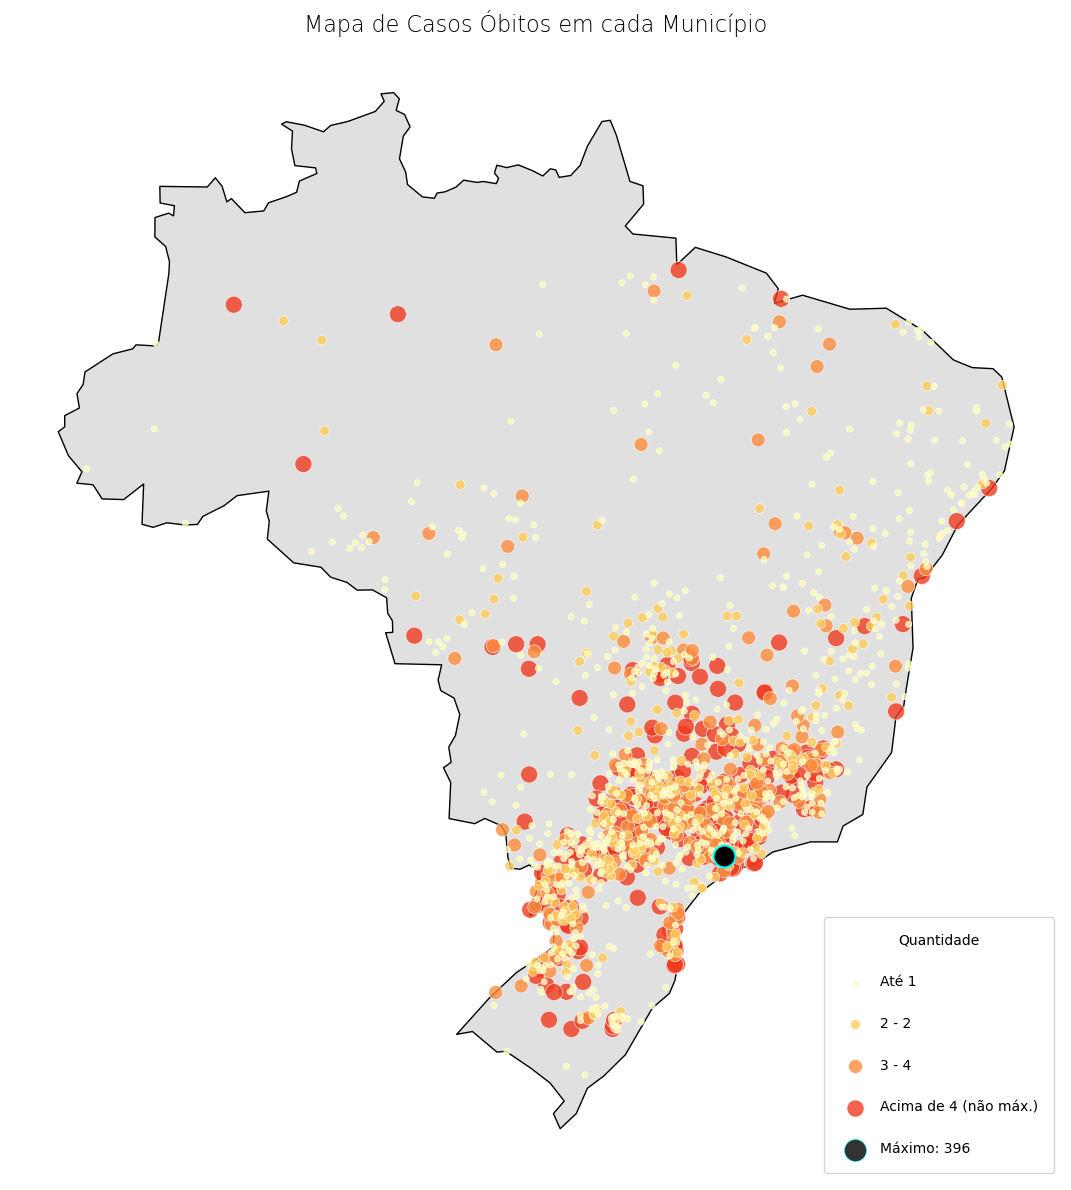

In [69]:
map_df(df_obito,"mapa_obito","Mapa de Casos Óbitos em cada Município")

In [44]:
df_obito_federativa = run_query("SELECT u.nome, COUNT(*) AS num_obitos FROM (notificacao_de_infectados AS i INNER JOIN municipios AS m ON i.cod_mun_infec = m.cod_mun) im NATURAL JOIN unidade_federativa u WHERE im.dt_obito IS NOT NULL  GROUP BY u.nome ORDER BY num_obitos DESC;")
df_obito_federativa


DataFrame carregado com sucesso


,nome,num_obitos
0,São Paulo,2803
1,Minas Gerais,1407
2,Paraná,904
3,Santa Catarina,369
4,Goiás,358
5,Rio Grande do Sul,279
6,Bahia,169
7,Mato Grosso,105
8,Mato Grosso do Sul,74
9,Pará,33


In [45]:
df_obito_doenca = run_query("SELECT t.desc, COUNT(*) AS quantidade FROM notificacao_de_infectados AS i INNER JOIN tipo_infectado AS t ON i.tipo_infec = t.id WHERE i.dt_obito IS NOT NULL GROUP BY t.desc ORDER BY quantidade DESC;")
df_obito_doenca


DataFrame carregado com sucesso


,desc,quantidade
0,dengue,6649
1,zika,15


In [46]:
df_doenca = run_query("SELECT t.desc, COUNT(*) AS quantidade FROM notificacao_de_infectados AS i INNER JOIN tipo_infectado AS t ON i.tipo_infec = t.id GROUP BY t.desc ORDER BY quantidade DESC;")
df_doenca


DataFrame carregado com sucesso


,desc,quantidade
0,dengue,4623020
1,zika,5183


In [84]:
df_mortalidade = run_query("SELECT u.nome AS estado, COUNT(i.dt_obito) AS total_de_obitos, COUNT(*) AS total_de_infectados, (CAST(COUNT(i.dt_obito) AS REAL)/ COUNT(*)) AS taxa_de_mortalidade_percentual FROM notificacao_de_infectados AS i JOIN municipios AS m ON i.cod_mun_infec = m.cod_mun JOIN unidade_federativa AS u ON m.cod_uf = u.cod_uf GROUP BY u.nome HAVING COUNT(*) > 0 ORDER BY taxa_de_mortalidade_percentual DESC;")
df_mortalidade


DataFrame carregado com sucesso


,estado,total_de_obitos,total_de_infectados,taxa_de_mortalidade_percentual
0,Espírito Santo,2,136,0.014706
1,Rio de Janeiro,3,347,0.008646
2,Sergipe,14,2707,0.005172
3,Maranhão,27,9636,0.002802
4,Bahia,169,84379,0.002003
5,Piauí,20,10028,0.001994
6,Amazonas,18,9204,0.001956
7,Rondônia,19,9772,0.001944
8,Rio Grande do Sul,279,147097,0.001897
9,Mato Grosso do Sul,74,41399,0.001787


In [5]:
query = """
SELECT
    u.nome,
    (CAST(COUNT(*) AS DECIMAL) / u.populacao) * 100000 AS infectados_por_100mil_hab
FROM
    notificacao_de_infectados AS i
INNER JOIN
    municipios AS m ON i.cod_mun_infec = m.cod_mun
INNER JOIN
    unidade_federativa AS u ON m.cod_uf = u.cod_uf
WHERE
    i.dt_notific BETWEEN '2023-01-01' AND '2023-12-31'
GROUP BY
    u.nome, u.populacao
ORDER BY
    infectados_por_100mil_hab DESC;
"""

df_infec_100mil_total = run_query(query)
df_infec_100mil_total


DataFrame carregado com sucesso


,nome,infectados_por_100mil_hab
0,Santa Catarina,1173.649975
1,Mato Grosso do Sul,1063.542319
2,Minas Gerais,947.916769
3,Paraná,900.555557
4,Goiás,629.561843
5,Mato Grosso,536.700842
6,São Paulo,498.662073
7,Rondônia,403.681770
8,Rio Grande do Sul,217.551007
9,Acre,199.393266


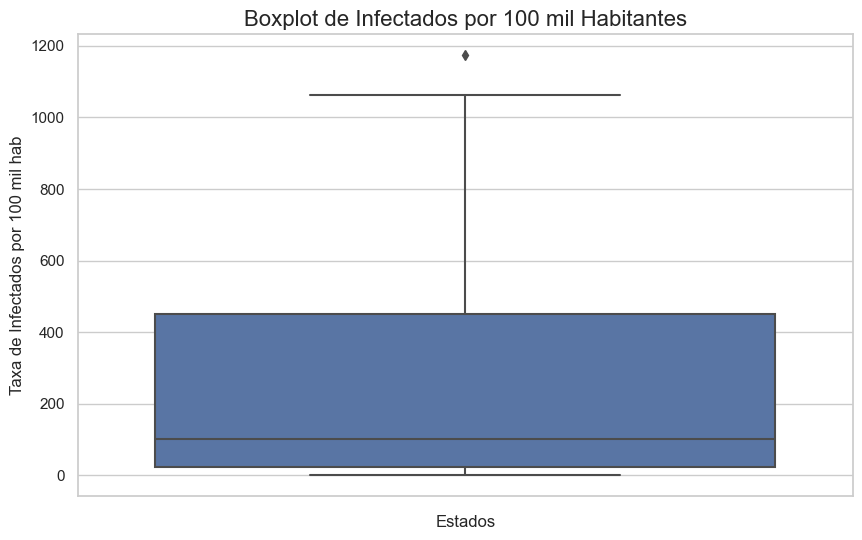

In [7]:
sns.set_theme(style="whitegrid")
plt.figure(figsize=(10, 6))

ax = sns.boxplot(y=df_infec_100mil_total['infectados_por_100mil_hab'])

ax.set_title('Boxplot de Infectados por 100 mil Habitantes', fontsize=16)
ax.set_ylabel('Taxa de Infectados por 100 mil hab', fontsize=12)
ax.set_xlabel('Estados', fontsize=12)

plt.savefig("infec_100.png", dpi=300)
plt.show()